In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.linalg import eigh
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

In [ ]:
def load_and_align_data(file_paths, index_col="Date"):
    dataframes = []
    tickers = {}
    for asset, file_path in file_paths.items():
        df = pd.read_excel(file_path, sheet_name=0)
        df = df.set_index(index_col)
        df.index = pd.to_datetime(df.index)
        tickers[asset] = df.columns.tolist()
        dataframes.append(df)
    # Align datasets
    aligned_data = dataframes[0]
    for df in dataframes[1:]:
        aligned_data = aligned_data.join(df, how="inner")
    # Reverse time
    return aligned_data[::-1], tickers

def drop_short_tickers(data, tickers, max_nan=50):
    short_tickers = data.columns[data.isnull().sum() > max_nan].tolist()
    print("Tickers to drop/replace due to insufficient data:")
    print(short_tickers)

    data = data.drop(columns=short_tickers)
    updated_tickers = {
        asset: [ticker for ticker in ticker_list if ticker not in short_tickers]
        for asset, ticker_list in tickers.items()
    }

    return data, updated_tickers

def compute_log_returns(price_df):
    log_returns = np.log(price_df / price_df.shift(1))
    return log_returns

def compute_pca(data, n_components=None):
    standardized_data = StandardScaler().fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(standardized_data)
    explained_variance_ratio = pca.explained_variance_ratio_
    return pca, pca_components, explained_variance_ratio

def discretize(contin_data, num_bins=12):
    std = np.std(contin_data)
    bins = std * np.arange(-num_bins//2, num_bins//2 + 1)
    return np.digitize(contin_data, bins)

def entropy(X):
    _, num_counts = np.unique(X, return_counts=True, axis=0)
    p = num_counts / sum(num_counts)
    ent = -np.sum(p * np.log(p))
    return ent

def MI(X, Y):
    mi = entropy(X) + entropy(Y) - entropy(np.column_stack((X, Y)))
    return mi

def surrogate_mi_test_shift(X, Y, num_surrogates=1000, significance_level=5):
    observed_mi = MI(X, Y)
    random_mi = []
    for _ in range(num_surrogates):
        shift = np.random.randint(len(X))
        X_shifted = np.roll(X, shift)
        random_mi.append(MI(X_shifted, Y))
    # Compute threshold
    threshold = np.percentile(random_mi, 100 - significance_level)
    return observed_mi, threshold, observed_mi > threshold

def sliding_window(data, window_size, step_size):
    """
    Generate sliding windows of data for all columns.

    Parameters:
    - data (pd.DataFrame): DataFrame with a datetime index and columns for assets/tickers.
    - window_size_years (int): Size of each sliding window in years.
    - step_size_years (int): Step size to slide the window forward in years.

    Returns:
    - windows (list of tuples): A list of tuples, where each tuple contains:
        - start_date (pd.Timestamp): Start date of the window.
        - end_date (pd.Timestamp): End date of the window.
        - window_data (pd.DataFrame): The sliced DataFrame for the window.
    """
    windows = []
    start_date = data.index.min()
    end_date = data.index.max()
    curr_date = start_date

    while curr_date + relativedelta(years=window_size) <= end_date:
        # Define the current window
        window_end_date = curr_date + relativedelta(years=window_size)
        window_data = data[(data.index >= curr_date) & (data.index < window_end_date)]

        # Store the window details
        windows.append((curr_date, window_end_date, window_data))

        # Move the window forward
        curr_date += relativedelta(years=step_size)


    return windows

def adf_test(timeseries, alpha=0.05):
    """
    Perform ADF test for stationarity.
    Returns:
    - bool: True if stationary (reject null hypothesis non stationary), 
            False otherwise.
    """
    dftest = adfuller(timeseries, autolag="AIC")
    test_stat = dftest[0]
    crit_val = dftest[4][f"{int(alpha*100)}%"]
    return test_stat < crit_val

def kpss_test(timeseries, alpha=0.05):
    """
    Perform KPSS test for stationarity.
    Returns:
    - bool: True if stationary (fail to reject null hypothesis stationary),
            False otherwise.
    """
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    test_stat = kpsstest[0]
    crit_val = kpsstest[3][f"{int(alpha*100)}%"]
    return not test_stat > crit_val

def stationarity_test(timeseries, alpha=0.05):
    """
    Combine ADF and KPSS tests for stationarity.

    Case 1: Both tests conclude that the series is not stationary 
            - The series is not stationary
    Case 2: Both tests conclude that the series is stationary 
            - The series is stationary
    Case 3: KPSS indicates stationarity and ADF indicates non-stationarity 
            - The series is trend stationary. Trend needs to be removed to make series strict stationary.
    Case 4: KPSS indicates non-stationarity and ADF indicates stationarity 
            - The series is difference stationary. Differencing is to be used to make series stationary.
    """
    adf_result = adf_test(timeseries, alpha)
    kpss_result = kpss_test(timeseries, alpha)

    if not adf_result and not kpss_result:
        return "Not Stationary"  # Case 1
    elif adf_result and kpss_result:
        return "Stationary"  # Case 2
    elif kpss_result and not adf_result:
        return "Trend Stationary"  # Case 3
    elif not kpss_result and adf_result:
        return "Difference Stationary"  # Case 4

In [4]:
# Define assets and file paths
assets = ["commodity", "credit", "currency", "energy", "equity", "metals", "real_estate", "volatility"]
file_paths = {asset: f"data/{asset}_data.xlsx" for asset in assets}

# Load data
aligned_data, tickers = load_and_align_data(file_paths)

# Drop tickers with many missing points
aligned_data, tickers = drop_short_tickers(aligned_data, tickers, max_nan=50)

# Compute log returns
log_returns = compute_log_returns(aligned_data)

# Drop NA
log_returns = log_returns.dropna()

Tickers to drop/replace due to insufficient data:
['FXJPEMCS', 'QCLN']


In [5]:
def check_stationarity_sliding(data, window_size=5, step_size=2, alpha=0.05):
    results = []

    windows = sliding_window(data, window_size=window_size, step_size=step_size)
    for start_date, end_date, window_data in windows:
        #print(f"Processing window: {start_date} to {end_date}")
        
        # Check each ticker in the current window
        for ticker in window_data.columns:
            series = window_data[ticker].dropna()
            if len(series) == 0:  # Skip empty or NaN-only series
                continue
            
            # Perform stationarity test
            stationarity_type = stationarity_test(series, alpha=alpha)
            if stationarity_type != "Stationary":
                # Append results for non-stationary tickers
                results.append({
                    "start_date": start_date,
                    "end_date": end_date,
                    "ticker": ticker,
                    "stationarity_type": stationarity_type,
                    "window_size_years": window_size,
                    "step_size_years": step_size
                })
    return results

In [6]:
def check_stationarity_to_dataframe(data, window_sizes, step_size=2, alpha=0.05):
    all_results = []

    for window_size in window_sizes:
        #print(f"Checking stationarity for window size: {window_size} years")
        results = check_stationarity_sliding(data, window_size=window_size, step_size=step_size, alpha=alpha)
        
        all_results.extend(results) 

    # Convert to DataFrame
    return pd.DataFrame(all_results)

window_sizes = [2, 4, 5, 6, 8, 18]
#results_df = check_stationarity_to_dataframe(log_returns, window_sizes, step_size=2)


In [7]:
#results_df

In [ ]:
# Perform PCA and discretization
asset_classes_discrete = {}
explained_variance_ratios = {}

for asset in assets:
    vals = log_returns[tickers[asset]]
    pca, pca_components, explained_variance_ratio = compute_pca(vals)
    explained_variance_ratios[asset] = explained_variance_ratio
    X = pca_components[:, 0]  # Take first principal component
    discrete_X = discretize(X)
    asset_classes_discrete[asset] = discrete_X

dates = log_returns.index
asset_classes_discrete = pd.DataFrame(asset_classes_discrete)
asset_classes_discrete.index = dates
asset_classes_discrete.index = pd.to_datetime(asset_classes_discrete.index)

In [84]:
def pca_and_discretize(log_returns, tickers, plot_explained_var_ratio=False):
    asset_classes_discrete = {}
    explained_variance_ratios = {}
    asset_classes = tickers.keys()
    for asset_class in asset_classes:
        vals = log_returns[tickers[asset_class]]
        pca, pca_components, explained_variance_ratio = compute_pca(vals)
        explained_variance_ratios[asset_class] = explained_variance_ratio
        X = pca_components[:, 0]  # Take first principal component
        discrete_X = discretize(X)
        asset_classes_discrete[asset_class] = discrete_X

    dates = log_returns.index
    asset_classes_discrete = pd.DataFrame(asset_classes_discrete)
    asset_classes_discrete.index = dates
    asset_classes_discrete.index = pd.to_datetime(asset_classes_discrete.index)

    if plot_explained_var_ratio:
        for asset, variance_ratio in explained_variance_ratios.items():
            plt.plot(np.cumsum(variance_ratio), marker="o", label=asset)
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("PCA Explained Variance Ratios")
        plt.legend()
        plt.show()
    return asset_classes_discrete

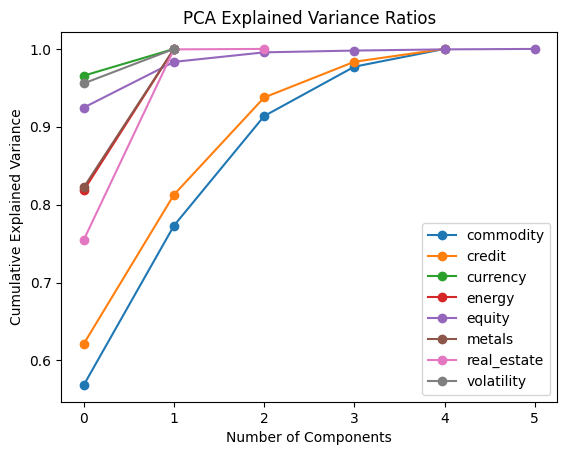

In [85]:
asset_classes_discrete = pca_and_discretize(log_returns, tickers, plot_explained_var_ratio=True)

In [82]:
asset_classes_discrete

commodity  credit  currency  energy  equity  metals  real_estate  \
Date                                                                           
2005-01-04          4       5        10       7       5       6            6   
2005-01-05          7       7         7       6       6       6            5   
2005-01-06          6       6         8       8       7       6            7   
2005-01-07          8       6         7       6       6       6            7   
2005-01-10          7       7         6       7       7       7            6   
...               ...     ...       ...     ...     ...     ...          ...   
2024-11-08          5       8         8       6       7       6            7   
2024-11-13          6       6         7       7       6       6            6   
2024-11-14          6       7         7       7       6       6            6   
2024-11-15          7       6         6       6       5       6            7   
2024-11-18          7       7         6       8       7       8            6   

            volatility  
Date                    
2005-01-04           7  
2005-01-05           7  
2005-01-06           6  
2005-01-07           6  
2005-01-10           7  
...                ...  
2024-11-08           6  
2024-11-13           6  
2024-11-14           7  
2024-11-15           8  
2024-11-18           6  

[4864 rows x 8 columns]

In [ ]:
tickers_discrete = {}
for asset in assets:
    for ticker in tickers[asset]:
        discrete_ticker = discretize(log_returns[ticker])
        tickers_discrete[ticker] = discrete_ticker

dates = log_returns.index
tickers_discrete = pd.DataFrame(tickers_discrete)
tickers_discrete.index = dates
tickers_discrete.index = pd.to_datetime(tickers_discrete.index)
tickers_discrete

BCOM  CRB CMDT  CRB METL  CRB RIND  SPGSAGP  MOODCAAA  LF98TRUU  \
Date                                                                          
2005-01-04     6         4         4         4        6         7         7   
2005-01-05     6         7         7         7        6         6         6   
2005-01-06     8         6         5         5        7         7         6   
2005-01-07     6         8         8         8        7         6         6   
2005-01-10     7         6         7         7        7         6         6   
...          ...       ...       ...       ...      ...       ...       ...   
2024-11-08     5         6         5         6        6         6         7   
2024-11-13     6         7         6         6        6         8         6   
2024-11-14     6         6         6         6        6         6         6   
2024-11-15     7         7         7         7        7         7         6   
2024-11-18     8         6         6         6        7         6         7   

            DJCBP  LMBITR  LC07TRUU  ...  CCMP  SML  SGX  BCOMPR  DJGSP  REIT  \
Date                                 ...                                        
2005-01-04      5       6         5  ...     5    5    6       6      5     6   
2005-01-05      7       7         6  ...     6    5    6       7      6     4   
2005-01-06      6       7         7  ...     6    7    7       5      6     7   
2005-01-07      6       7         6  ...     6    6    7       6      7     7   
2005-01-10      7       7         7  ...     7    7    7       7      7     6   
...           ...     ...       ...  ...   ...  ...  ...     ...    ...   ...   
2024-11-08      8      10         7  ...     7    7    7       6      6     7   
2024-11-13      5       7         6  ...     6    6    6       6      6     7   
2024-11-14      6       7         6  ...     6    6    6       6      7     6   
2024-11-15      6       6         6  ...     5    6    5       6      6     7   
2024-11-18      7       7         7  ...     7    6    7       8      8     7   

            DJUSRE  EPRA  VIX  VXN  
Date                                
2005-01-04       6     6    6    7  
2005-01-05       4     6    7    7  
2005-01-06       7     6    6    6  
2005-01-07       7     8    6    6  
2005-01-10       6     7    6    7  
...            ...   ...  ...  ...  
2024-11-08       7     8    6    6  
2024-11-13       7     5    6    6  
2024-11-14       6     7    7    7  
2024-11-15       7     7    8    8  
2024-11-18       7     5    6    6  

[4864 rows x 27 columns]

In [86]:
def discretize_tickers(log_returns, tickers):
    tickers_discrete = {}
    asset_classes = tickers.keys()
    for asset_class in asset_classes:
        for ticker in tickers[asset_class]:
            discrete_ticker = discretize(log_returns[ticker])
            tickers_discrete[ticker] = discrete_ticker

    dates = log_returns.index
    tickers_discrete = pd.DataFrame(tickers_discrete)
    tickers_discrete.index = dates
    tickers_discrete.index = pd.to_datetime(tickers_discrete.index)
    return tickers_discrete

In [87]:
tickers_discrete = discretize_tickers(log_returns, tickers)
tickers_discrete

BCOM  CRB CMDT  CRB METL  CRB RIND  SPGSAGP  MOODCAAA  LF98TRUU  \
Date                                                                          
2005-01-04     6         4         4         4        6         7         7   
2005-01-05     6         7         7         7        6         6         6   
2005-01-06     8         6         5         5        7         7         6   
2005-01-07     6         8         8         8        7         6         6   
2005-01-10     7         6         7         7        7         6         6   
...          ...       ...       ...       ...      ...       ...       ...   
2024-11-08     5         6         5         6        6         6         7   
2024-11-13     6         7         6         6        6         8         6   
2024-11-14     6         6         6         6        6         6         6   
2024-11-15     7         7         7         7        7         7         6   
2024-11-18     8         6         6         6        7         6         7   

            DJCBP  LMBITR  LC07TRUU  ...  CCMP  SML  SGX  BCOMPR  DJGSP  REIT  \
Date                                 ...                                        
2005-01-04      5       6         5  ...     5    5    6       6      5     6   
2005-01-05      7       7         6  ...     6    5    6       7      6     4   
2005-01-06      6       7         7  ...     6    7    7       5      6     7   
2005-01-07      6       7         6  ...     6    6    7       6      7     7   
2005-01-10      7       7         7  ...     7    7    7       7      7     6   
...           ...     ...       ...  ...   ...  ...  ...     ...    ...   ...   
2024-11-08      8      10         7  ...     7    7    7       6      6     7   
2024-11-13      5       7         6  ...     6    6    6       6      6     7   
2024-11-14      6       7         6  ...     6    6    6       6      7     6   
2024-11-15      6       6         6  ...     5    6    5       6      6     7   
2024-11-18      7       7         7  ...     7    6    7       8      8     7   

            DJUSRE  EPRA  VIX  VXN  
Date                                
2005-01-04       6     6    6    7  
2005-01-05       4     6    7    7  
2005-01-06       7     6    6    6  
2005-01-07       7     8    6    6  
2005-01-10       6     7    6    7  
...            ...   ...  ...  ...  
2024-11-08       7     8    6    6  
2024-11-13       7     5    6    6  
2024-11-14       6     7    7    7  
2024-11-15       7     7    8    8  
2024-11-18       7     5    6    6  

[4864 rows x 27 columns]

In [ ]:
# MI over rolling windows
asset_pairs = list(itertools.combinations(assets, 2))
mi_results = {asset_pair: [] for asset_pair in asset_pairs}
window_len = 2
window_step = 1
windows = sliding_window(asset_classes_discrete, window_len, window_step)
for start_date, end_date, window_data in windows:
    for asset1, asset2 in asset_pairs:
        mi = MI(window_data[asset1], window_data[asset2])
        mi_results[(asset1, asset2)].append(mi)

In [11]:
# Filter for the most significant relationships
top_mi = []
for asset_pair, mi in mi_results.items():
    mean_mi = np.mean(mi)
    if mean_mi > 0.05:
        top_mi.append(asset_pair)
print(top_mi)

[('commodity', 'credit'), ('commodity', 'currency'), ('commodity', 'energy'), ('commodity', 'equity'), ('commodity', 'metals'), ('commodity', 'real_estate'), ('commodity', 'volatility'), ('credit', 'currency'), ('credit', 'energy'), ('credit', 'equity'), ('credit', 'metals'), ('credit', 'real_estate'), ('credit', 'volatility'), ('currency', 'energy'), ('currency', 'equity'), ('currency', 'metals'), ('currency', 'real_estate'), ('currency', 'volatility'), ('energy', 'equity'), ('energy', 'metals'), ('energy', 'real_estate'), ('energy', 'volatility'), ('equity', 'metals'), ('equity', 'real_estate'), ('equity', 'volatility'), ('metals', 'real_estate'), ('metals', 'volatility'), ('real_estate', 'volatility')]


C:\Users\akhma\AppData\Local\Temp\ipykernel_14676\1802631945.py:5: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(midpoints, mi_results[asset_pair], label=asset_pair)


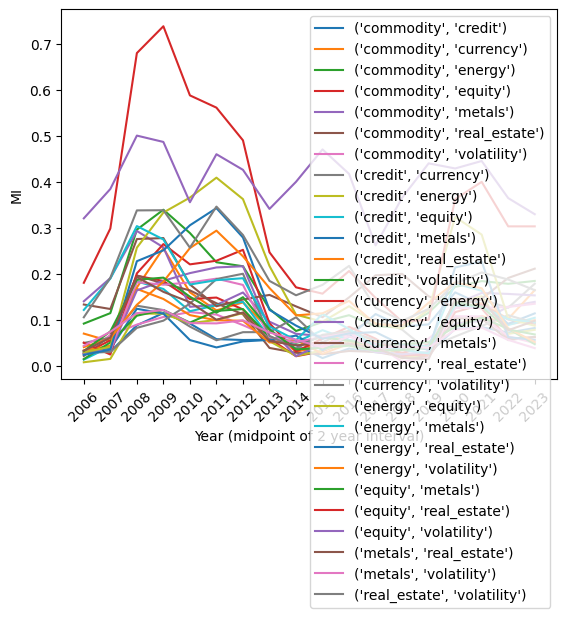

In [12]:
# Plotting
midpoints = [(start_date + (end_date - start_date) // 2) for start_date, end_date, _ in windows]

for asset_pair in top_mi:
    plt.plot(midpoints, mi_results[asset_pair], label=asset_pair)

plt.xticks(midpoints, [str(mid.year) for mid in midpoints], rotation=45)  # Label with years, rotated for readability
plt.ylabel("MI")
plt.xlabel(f"Year (midpoint of {window_len} year interval)")
plt.legend()
plt.show()

In [13]:
import networkx as nx

In [14]:
def create_network(data, edge="mi", threshold=0.05):

    G = nx.Graph()
    assets = data.columns

    for asset in assets:
        G.add_node(asset)

    edge_weights = {}

    if edge == "mi":
        for (a1, a2) in itertools.combinations(assets, 2):
            mi = MI(data[a1], data[a2])
            G.add_edge(a1, a2, weight=mi)
            edge_weights[(a1, a2)] = mi

    return G

In [15]:
mi_network = create_network(tickers_discrete)

In [16]:
def louvain_communities(graph):
    louvain_communities = nx.algorithms.community.louvain_communities(graph)

    louvain_community_dict = {}
    for i, community in enumerate(louvain_communities):
        for node in community:
            louvain_community_dict[node] = i
    louvain_labels = [louvain_community_dict[node] for node in mi_network.nodes()]
    return louvain_labels


In [17]:
# Pygenstability communities
import pygenstability as pgs

def pgs_communities(graph, min_scale=0.75, max_scale=3, 
                    n_scale=30, log_scale=False, method='leiden'):
    adj_matrix = nx.to_scipy_sparse_array(graph)
    results = pgs.run(
        graph=adj_matrix,
        min_scale=min_scale,            # Adjusted from default -2.0
        max_scale=max_scale,            # Adjusted from default 0.5
        n_scale=n_scale,               
        log_scale=log_scale,                       
        method=method,         
    )
    return results

In [18]:
def custom_plot_communities(graph, min_scale=0.75 , max_scale=3, 
                    n_scale=30, log_scale=False, method='leiden'):
    """Plot communities with using pgs and Louvain"""
    pos = nx.spring_layout(graph, seed=21)  
    
    pgs_results = pgs_communities(
        graph, 
        min_scale=min_scale,
        max_scale=max_scale,
        n_scale=n_scale,               
        log_scale=log_scale,                       
        method=method,
        )
    
    for scale_id in pgs_results['selected_partitions']:
        communities = pgs_results['community_id'][scale_id]
        
        plt.figure(figsize=(10,8))
        nx.draw(graph, pos, 
               node_color=communities,
               cmap=plt.cm.tab20,
               with_labels=True,
               width = [graph[a1][a2]['weight']*5 for a1, a2 in graph.edges()]
               )
        
        plt.title(f"Pygenstability Leiden: Scale {pgs_results['scales'][scale_id]:.2f}")

    louvain_labels = louvain_communities(graph)
    plt.figure(figsize=(10, 8))
    nx.draw(
        graph, pos,
        node_color=louvain_labels,
        cmap=plt.cm.tab20,
        with_labels=True,
        width=[graph[a1][a2]['weight'] * 5 for a1, a2 in graph.edges()]
    )
    plt.title("Louvain Community Detection")

In [19]:
tickers

{'commodity': ['BCOM', 'CRB CMDT', 'CRB METL', 'CRB RIND', 'SPGSAGP'],
 'credit': ['MOODCAAA', 'LF98TRUU', 'DJCBP', 'LMBITR', 'LC07TRUU'],
 'currency': ['DXY', 'BBDXY'],
 'energy': ['MXWO0EN', 'SPGSEN'],
 'equity': ['SPX', 'NDX', 'RTY', 'CCMP', 'SML', 'SGX'],
 'metals': ['BCOMPR', 'DJGSP'],
 'real_estate': ['REIT', 'DJUSRE', 'EPRA'],
 'volatility': ['VIX', 'VXN']}

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 249.76it/s]


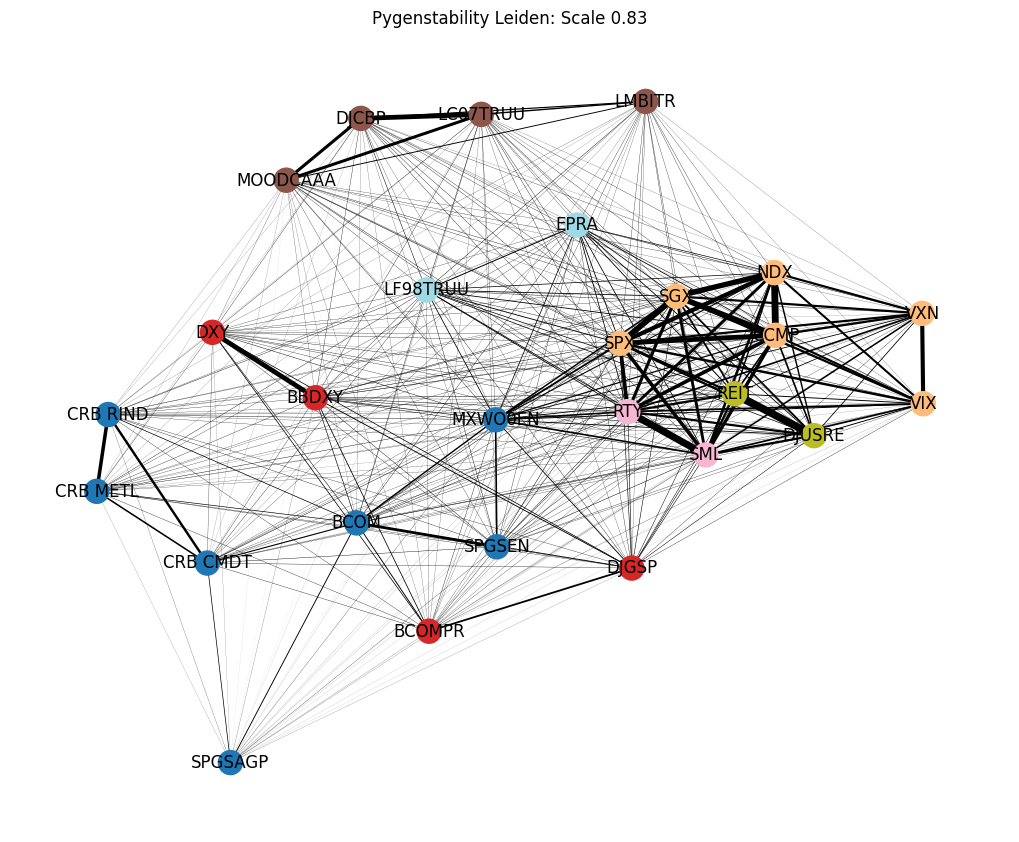

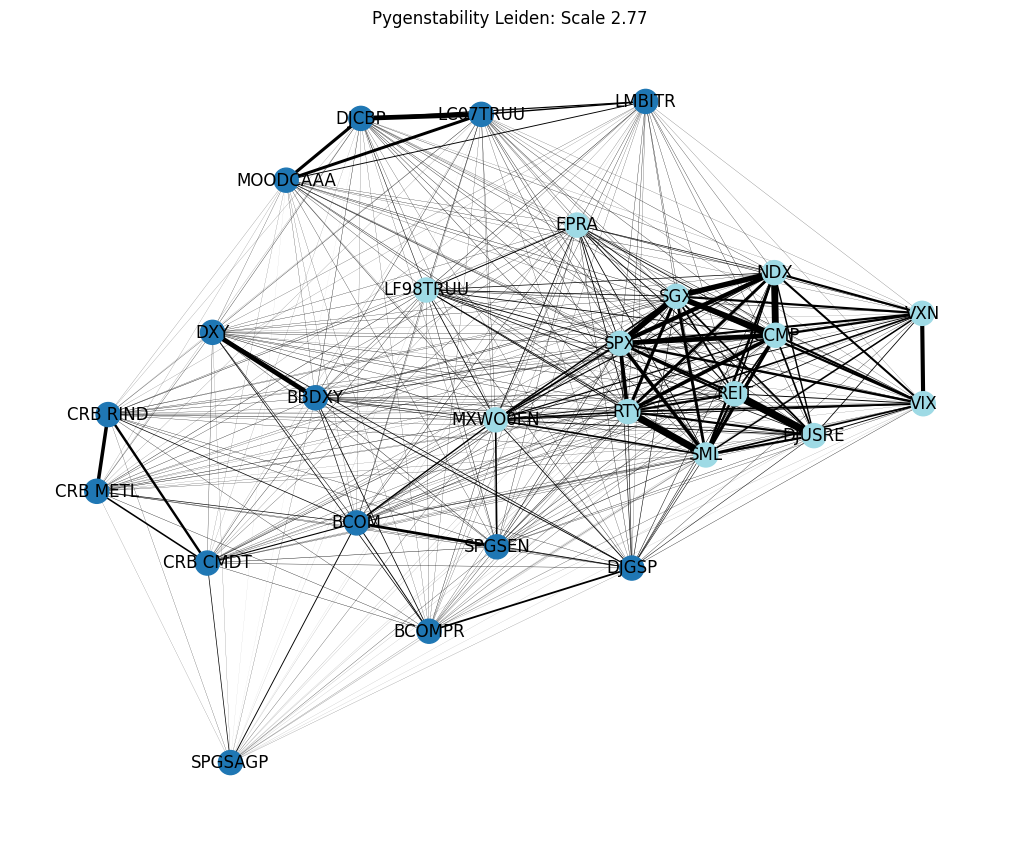

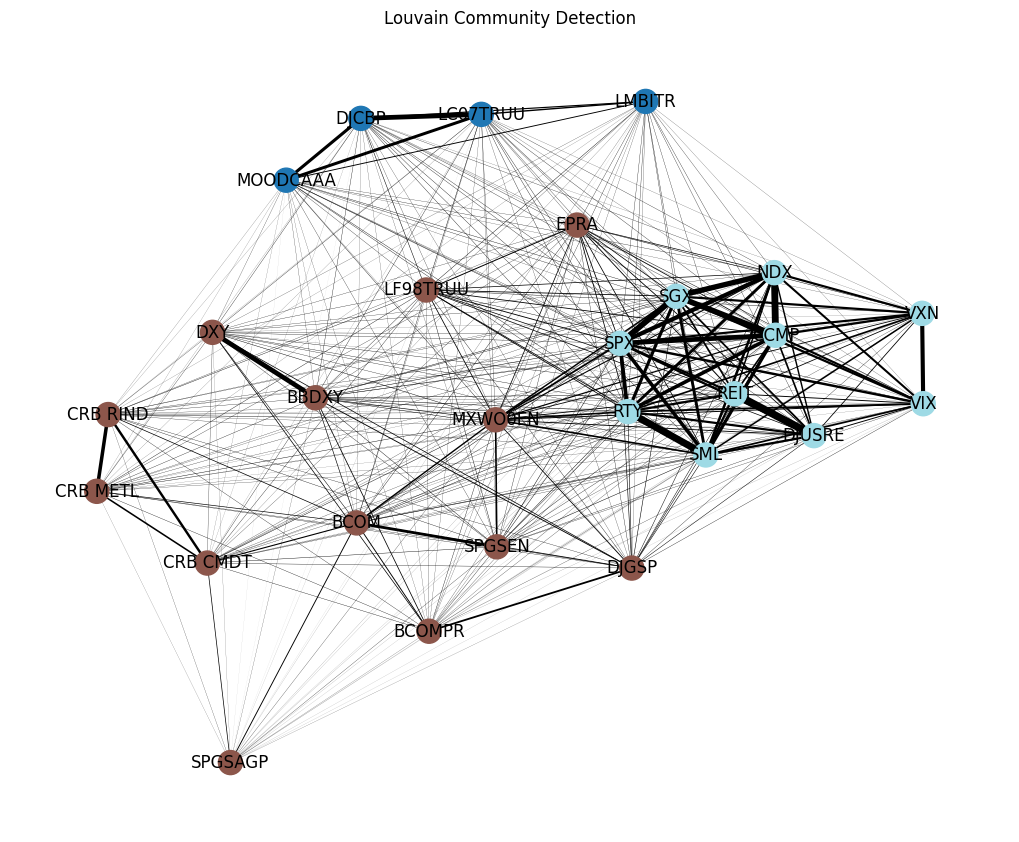

In [20]:
custom_plot_communities(mi_network)

In [21]:
import backboning

In [22]:
import os
def backbone(graph, graph_name, method, threshold):
    # Prepare graph for backboning package
    edges = [(u, v , d["weight"]) for u, v, d in graph.edges(data=True)]
    df_edges = pd.DataFrame(edges, columns=["src", "trg", "weight"])
    df_edges.to_csv(f"{graph_name}_edges.csv", index=False)
    table, _, _ = backboning.read(f".\{graph_name}_edges.csv", 
                                             column_of_interest="weight", 
                                             sep=",", 
                                             undirected=True)
    os.remove(f"{graph_name}_edges.csv")
    # Backbone
    if method == "noise_corrected":
        nc_table = backboning.noise_corrected(table)
        backbone_table = backboning.thresholding(nc_table, threshold=threshold)
    elif method == "disparity_filter":
        dspf_table = backboning.disparity_filter(table)
        backbone_table = backboning.thresholding(dspf_table, threshold=threshold)
    elif method == "naive_threshold":
        backbone_table = table[table["nij"] > threshold]
    

    # Turn table back into graph
    G_backbone = nx.Graph()
    for _, row in backbone_table.iterrows():
        G_backbone.add_edge(row["src"], row["trg"], weight=row["nij"])

    return G_backbone

In [23]:
mi_network_nc = backbone(mi_network, "mi_network", "noise_corrected", 0.1)
mi_network_dspf = backbone(mi_network, "mi_network", "disparity_filter", 0.5)
mi_network_naive = backbone(mi_network, "mi_network", "naive_threshold", 0.05)

Calculating NC score...
Calculating DF score...


In [24]:
def plot_graph(graph, pos, title):
    plt.figure(figsize=(12, 8))
    edges = graph.edges(data=True)
    weights = [w["weight"] for _, _, w in edges]

    nx.draw_networkx_nodes(graph, pos)
    nx.draw_networkx_edges(graph, pos, width=[w * 5 for w in weights], alpha=0.7)
    nx.draw_networkx_labels(graph, pos, font_size=10)
    
    plt.title(title)
    plt.show()

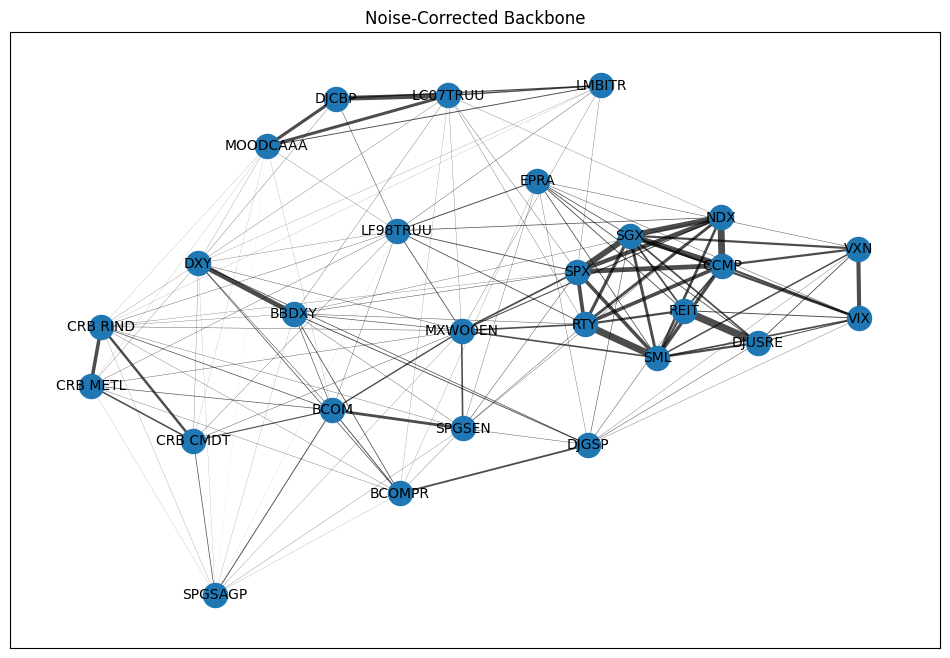

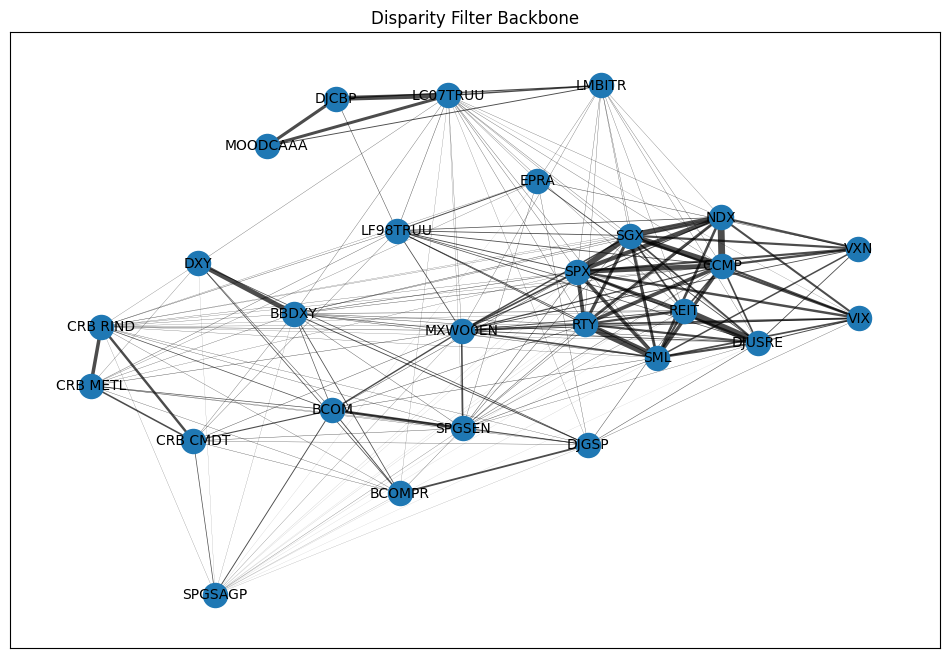

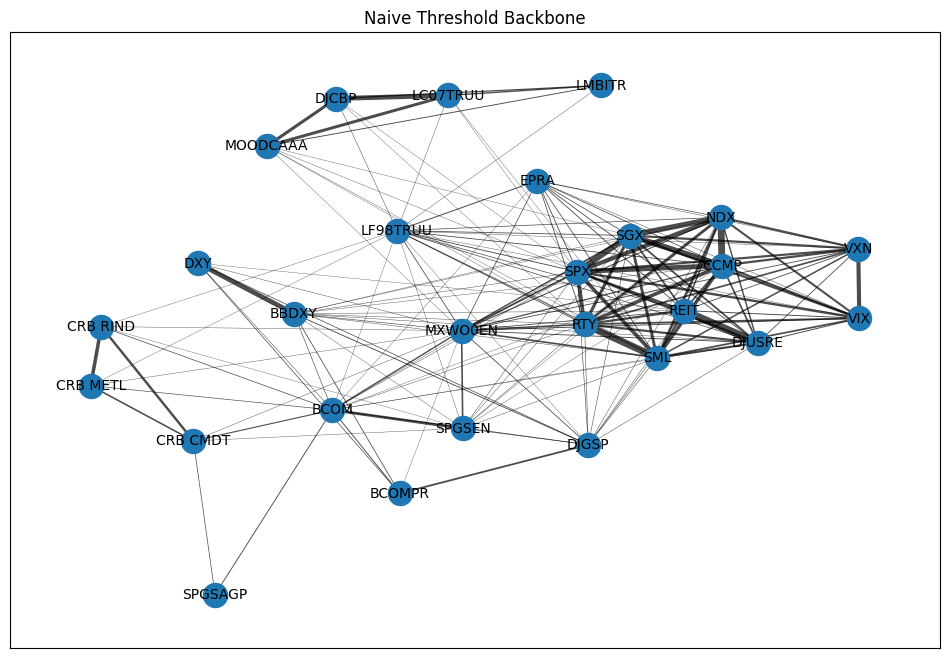

In [25]:
fixed_pos = nx.spring_layout(mi_network, seed=21)
plot_graph(mi_network_nc, fixed_pos, title="Noise-Corrected Backbone")
plot_graph(mi_network_dspf, fixed_pos, title="Disparity Filter Backbone")
plot_graph(mi_network_naive, fixed_pos, title="Naive Threshold Backbone")

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 490.32it/s]


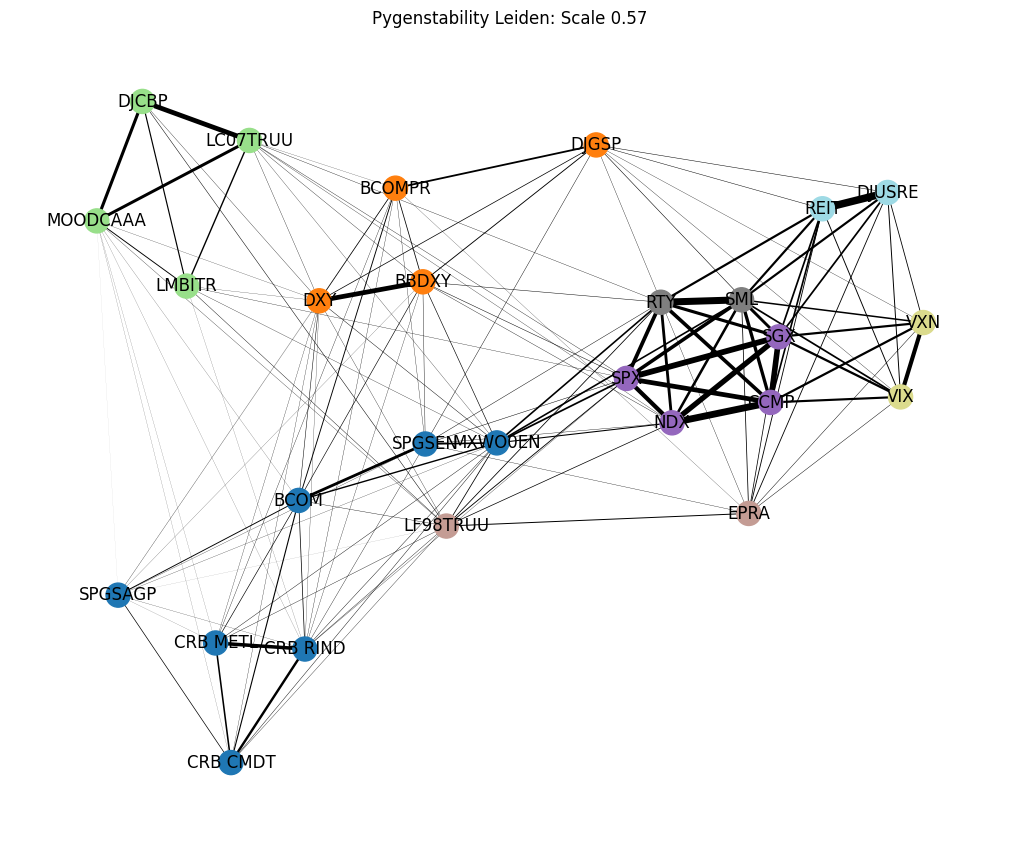

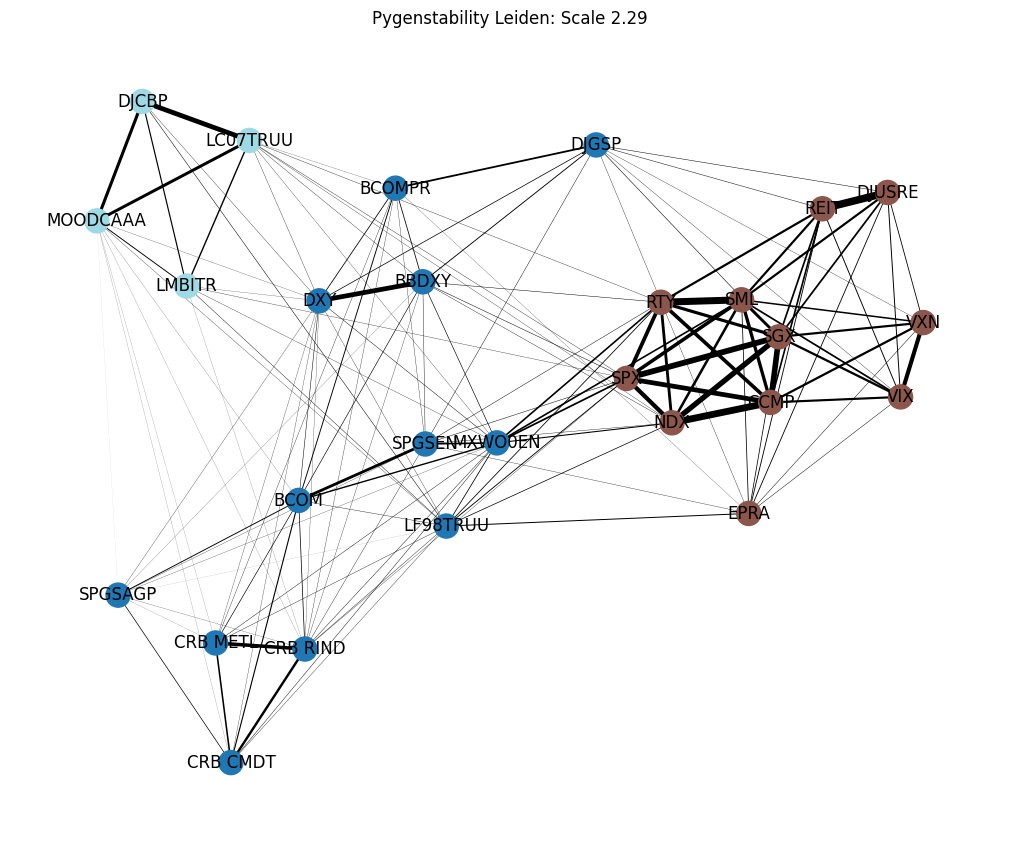

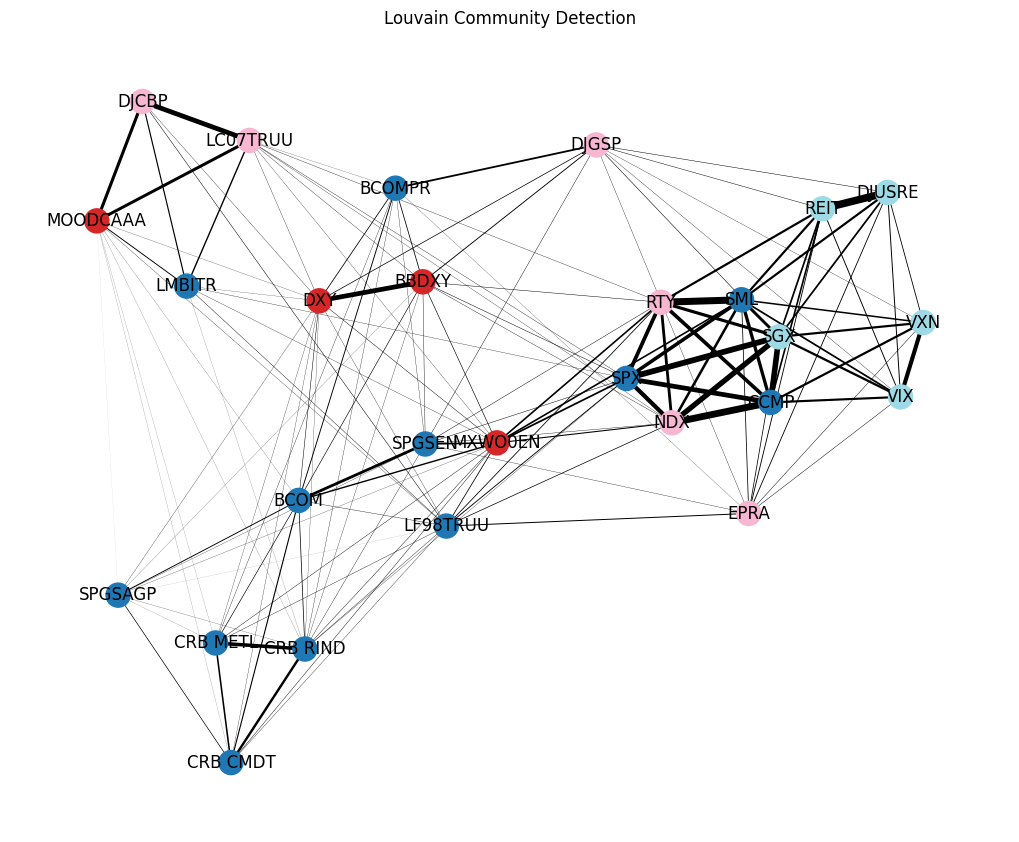

In [26]:
custom_plot_communities(mi_network_nc, min_scale=0.5, max_scale=2.5)

In [27]:
def create_true_labels(graph, ticker_dict):
    """Map graph nodes to true asset class labels"""
    true_mapping = {}
    for asset_class, symbols in ticker_dict.items():
        for symbol in symbols:
            true_mapping[symbol] = asset_class
    
    classes = list(ticker_dict.keys())
    class_to_id = {cls: idx for idx, cls in enumerate(classes)}
    
    return [class_to_id[true_mapping[node]] for node in graph.nodes()]

true_labels = create_true_labels(mi_network, tickers)

In [58]:
def nvi(true_labels, detected_labels):

    mi = MI(true_labels, detected_labels)

    h_true = entropy(true_labels)
    h_detected = entropy(detected_labels)

    vi = h_true + h_detected - 2 * mi

    return vi / (h_true + h_detected - mi) if (h_true + h_detected - mi) > 0 else 0

In [29]:
pgs_results = pgs_communities(mi_network_nc, min_scale=0.5, max_scale=2.5)

100%|██████████| 30/30 [00:00<00:00, 423.62it/s]


In [40]:
def pgs_optimal_param(graph, true_labels, min_scales):
    nvis = []
    for min_scale in min_scales:
        pgs_results = pgs_communities(graph, 
                                      min_scale=min_scale, 
                                      max_scale=2.5, 
                                      n_scale=20)
        first_scale = pgs_results['selected_partitions'][0]
        pgs_community = pgs_results['community_id'][first_scale]
        print(nvi(true_labels, pgs_community))
        nvis.append(nvi(true_labels, pgs_community))
    return nvis

In [59]:
pgs_optimal_param(mi_network, true_labels, np.linspace(0.3, 0.7, 5))

100%|██████████| 20/20 [00:00<00:00, 488.15it/s]
c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pygenstability\optimal_scales.py:39: RuntimeWarning:

Mean of empty slice



0.2980669817714605


100%|██████████| 20/20 [00:00<00:00, 500.53it/s]


0.3294785709106632


100%|██████████| 20/20 [00:00<00:00, 483.18it/s]


0.30941975408887706


100%|██████████| 20/20 [00:00<00:00, 450.50it/s]


0.2694099512038157


100%|██████████| 20/20 [00:00<00:00, 496.09it/s]


0.2694099512038157


[np.float64(0.2980669817714605),
 np.float64(0.3294785709106632),
 np.float64(0.30941975408887706),
 np.float64(0.2694099512038157),
 np.float64(0.2694099512038157)]

100%|██████████| 20/20 [00:00<00:00, 442.20it/s]
c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pygenstability\optimal_scales.py:39: RuntimeWarning:

Mean of empty slice



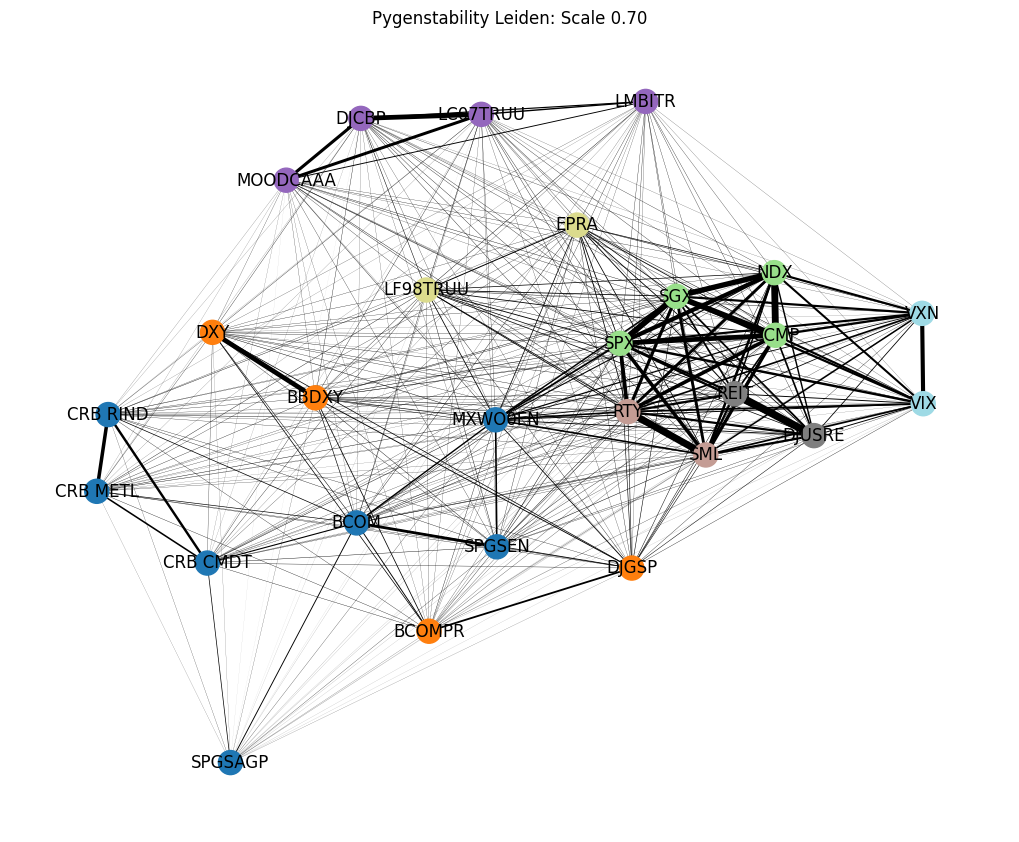

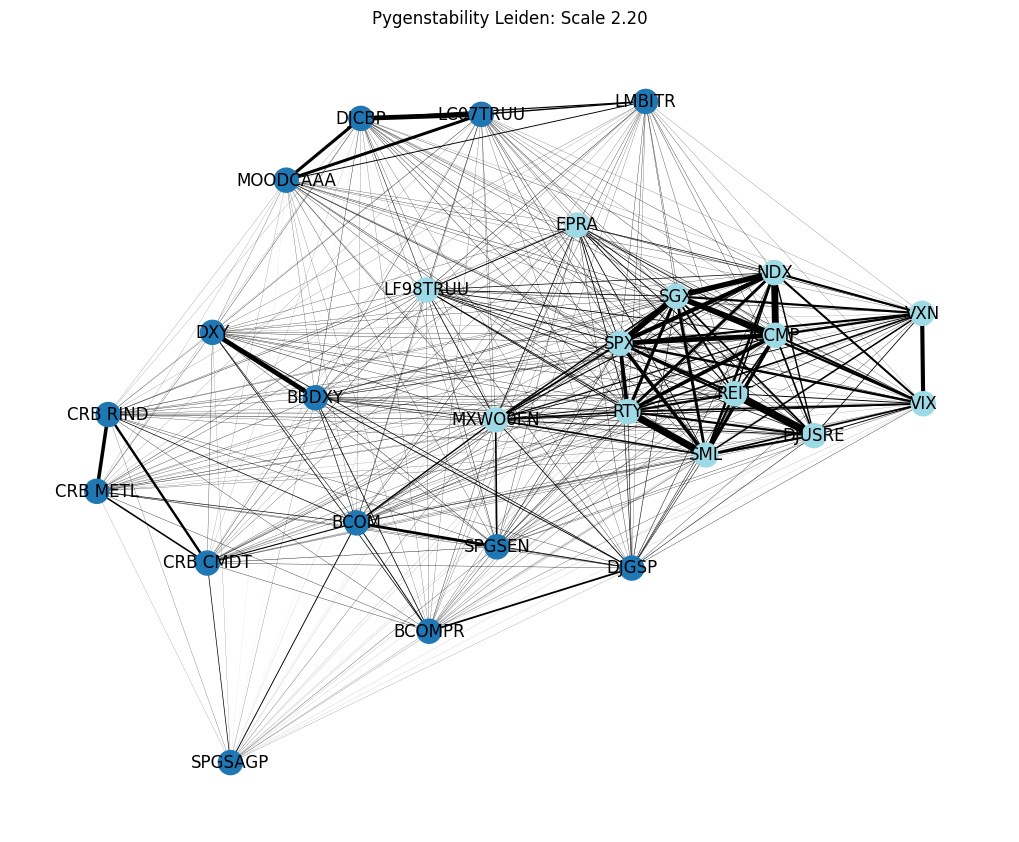

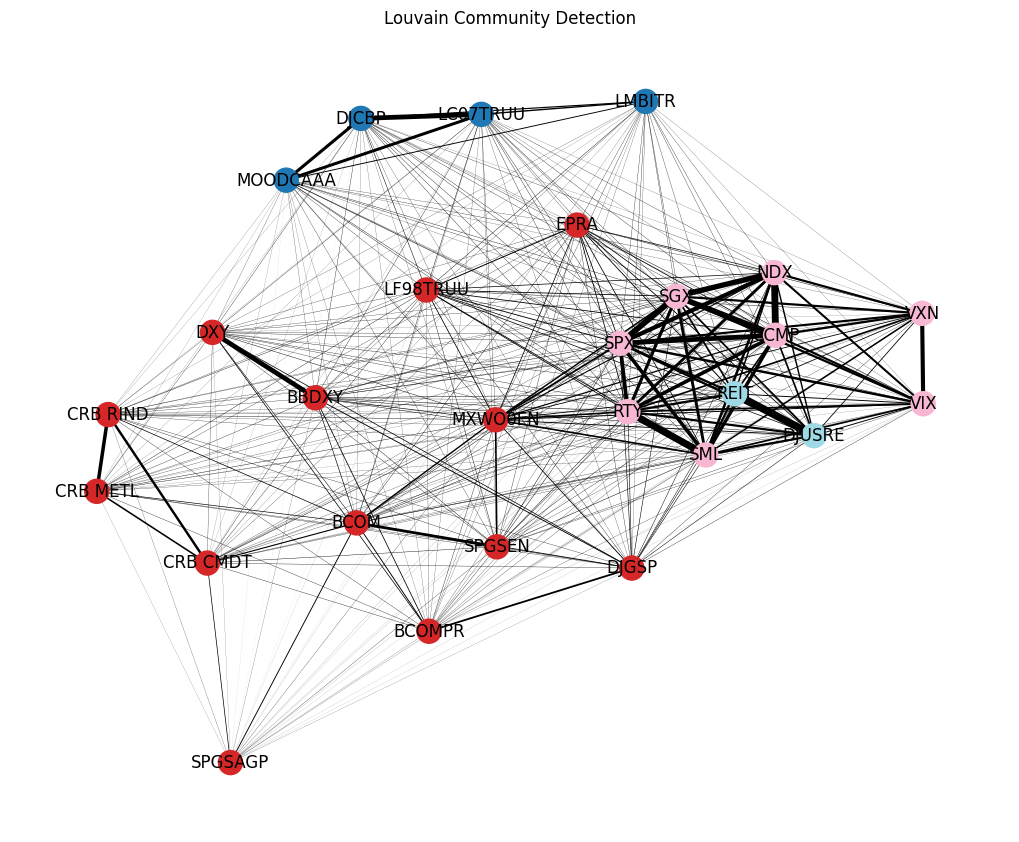

In [54]:
custom_plot_communities(mi_network, min_scale=0.6, max_scale=2.5, n_scale=20)

In [60]:
pgs_optimal_param(mi_network_nc, true_labels, np.linspace(0.1, 0.5, 5))

100%|██████████| 20/20 [00:00<00:00, 627.31it/s]


0.43037032737911274


100%|██████████| 20/20 [00:00<00:00, 650.78it/s]


0.4886965303513223


100%|██████████| 20/20 [00:00<00:00, 597.96it/s]


0.567293337195456


100%|██████████| 20/20 [00:00<00:00, 515.78it/s]


0.5842962253404144


100%|██████████| 20/20 [00:00<00:00, 538.65it/s]


0.637710970492748


[np.float64(0.43037032737911274),
 np.float64(0.4886965303513223),
 np.float64(0.567293337195456),
 np.float64(0.5842962253404144),
 np.float64(0.637710970492748)]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 585.81it/s]
c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pygenstability\optimal_scales.py:39: RuntimeWarning:

Mean of empty slice



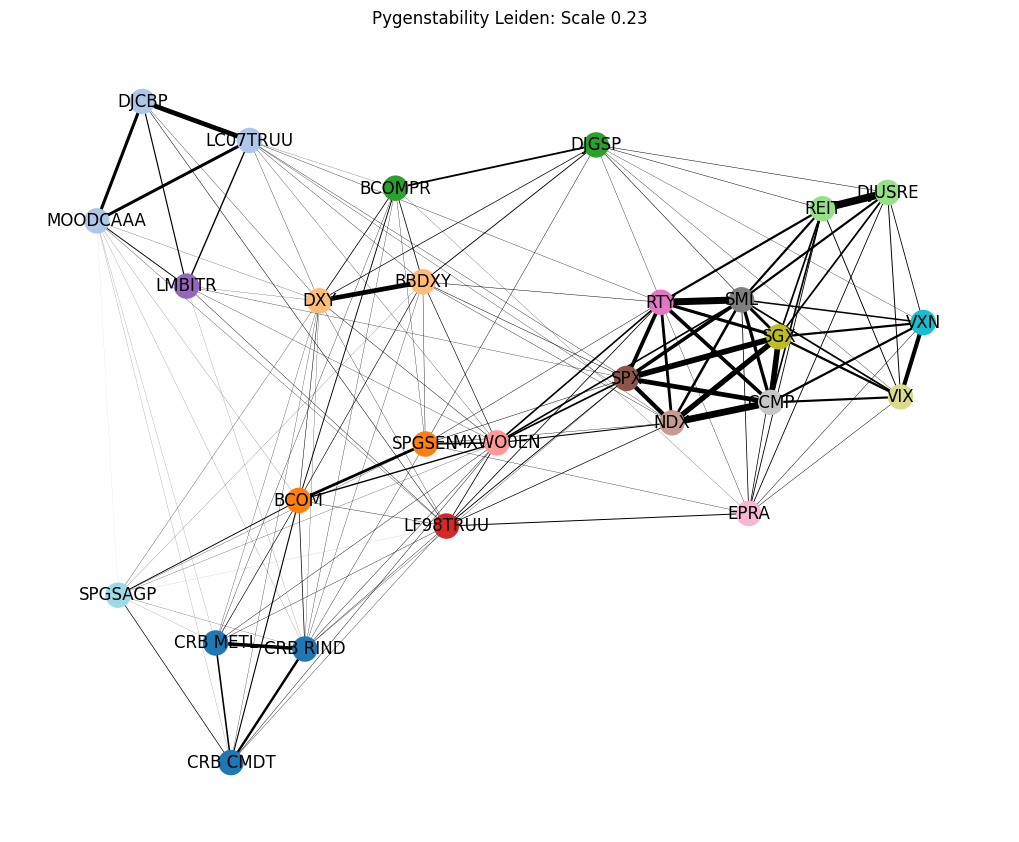

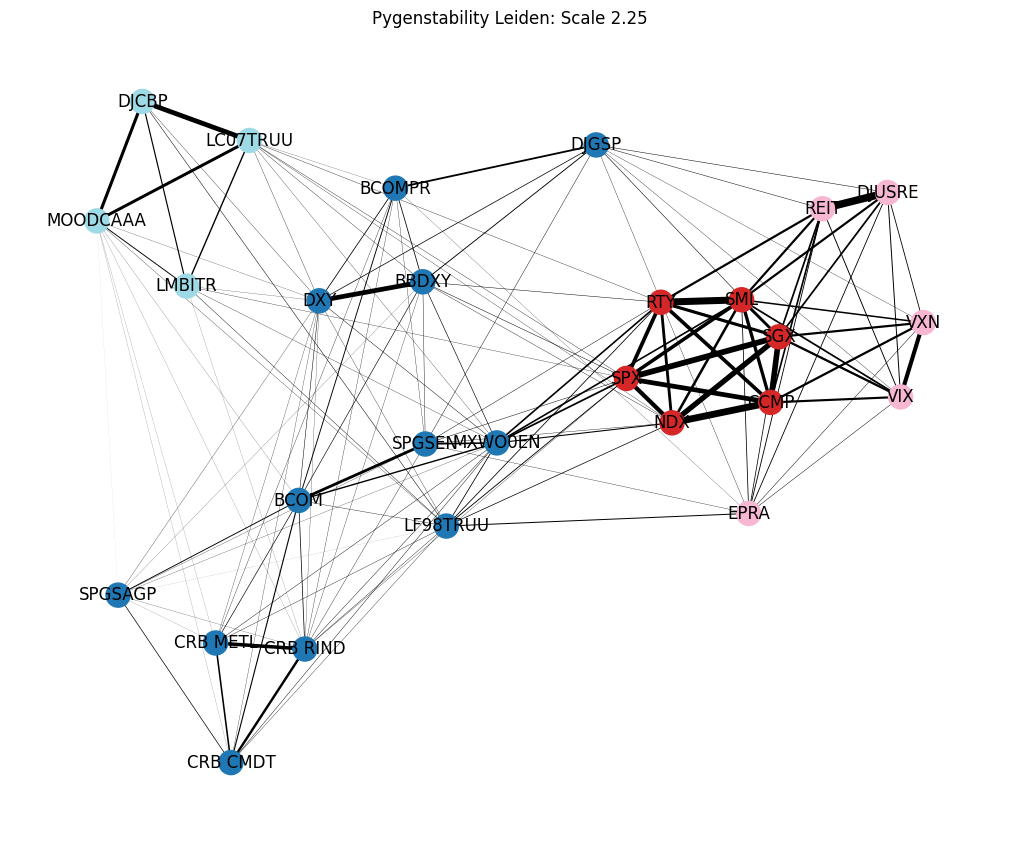

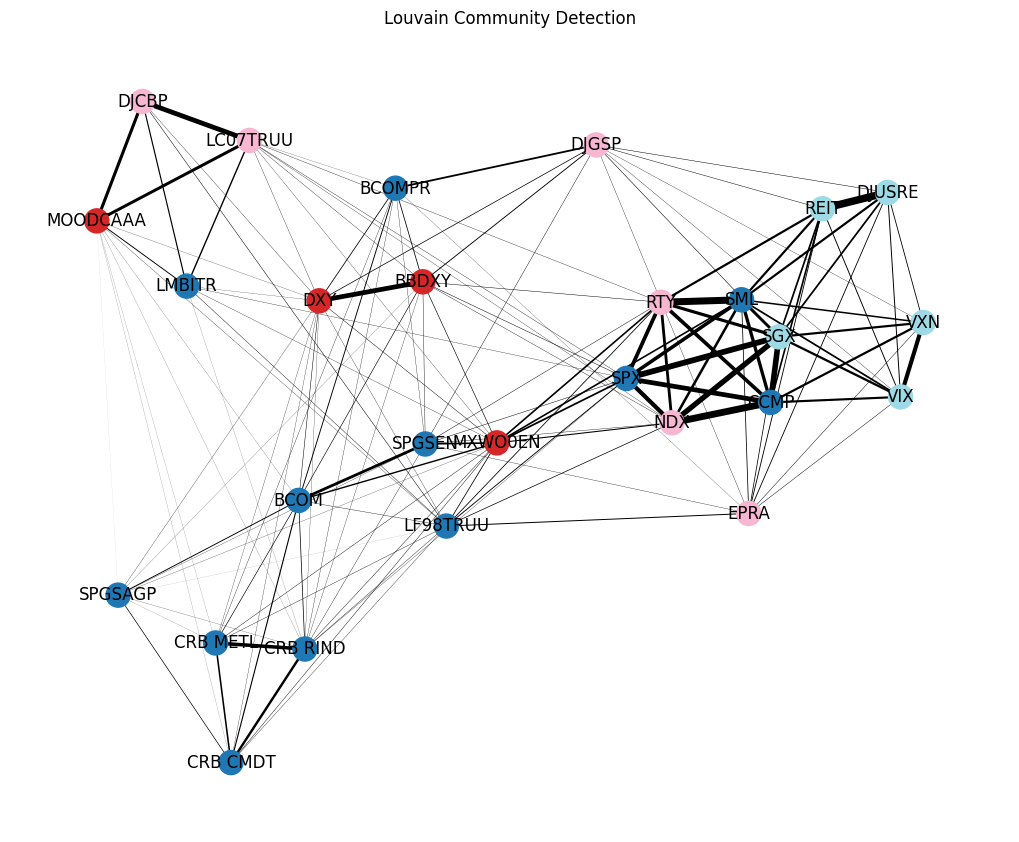

In [56]:
custom_plot_communities(mi_network_nc, min_scale=0.1, max_scale=2.5, n_scale=20)

In [ ]:
def network_properties(G):

    analysis = {}

    analysis['n_nodes'] = G.number_of_nodes()
    analysis['n_edges'] = G.number_of_edges()

    degrees = dict(G.degree(weight="weight"))
    analysis['degree'] = pd.Series(degrees)
    analysis['e_vector_centr'] = nx.eigenvector_centrality(G, weight="weight")

    analysis['avg_clustering'] = nx.average_clustering(G, weight="weight")
    
    analysis['avg_shortest_path_length'] = nx.average_shortest_path_length(G)

    L = nx.laplacian_matrix(G).toarray()
    e_vals = eigh(L, eigvals_only=True)
    analysis['alg_connectivity'] = e_vals[1]

    return pd.DataFrame(analysis)
    

In [ ]:
network_properties(mi_network_nc)

n_nodes  n_edges    degree  e_vector_centr  avg_clustering  \
BCOM           27      137  1.465491        0.011863        0.101273   
CRB CMDT       27      137  1.002801        0.004425        0.101273   
CRB METL       27      137  1.060968        0.004619        0.101273   
CRB RIND       27      137  1.354610        0.009342        0.101273   
SPGSAGP        27      137  0.432339        0.002409        0.101273   
MOODCAAA       27      137  1.168216        0.004290        0.101273   
LF98TRUU       27      137  1.030511        0.043078        0.101273   
DXY            27      137  1.353954        0.009562        0.101273   
BBDXY          27      137  1.464138        0.027185        0.101273   
MXWO0EN        27      137  1.872804        0.099736        0.101273   
SPGSEN         27      137  1.125446        0.030036        0.101273   
BCOMPR         27      137  0.827054        0.004482        0.101273   
LMBITR         27      137  0.697348        0.008490        0.101273   
SPX            27      137  3.836604        0.375540        0.101273   
DJCBP          27      137  1.423261        0.005877        0.101273   
LC07TRUU       27      137  1.620176        0.019117        0.101273   
NDX            27      137  3.540867        0.371876        0.101273   
RTY            27      137  3.785406        0.358262        0.101273   
EPRA           27      137  0.865579        0.044155        0.101273   
DJGSP          27      137  0.911843        0.022352        0.101273   
SML            27      137  4.227200        0.367165        0.101273   
CCMP           27      137  4.348190        0.424204        0.101273   
SGX            27      137  4.609317        0.417296        0.101273   
REIT           27      137  2.530527        0.176862        0.101273   
VIX            27      137  1.868123        0.141865        0.101273   
VXN            27      137  1.682518        0.132713        0.101273   
DJUSRE         27      137  2.098829        0.132824        0.101273   

          avg_shortest_path_length  alg_connectivity  
BCOM                      1.757835          0.195727  
CRB CMDT                  1.757835          0.195727  
CRB METL                  1.757835          0.195727  
CRB RIND                  1.757835          0.195727  
SPGSAGP                   1.757835          0.195727  
MOODCAAA                  1.757835          0.195727  
LF98TRUU                  1.757835          0.195727  
DXY                       1.757835          0.195727  
BBDXY                     1.757835          0.195727  
MXWO0EN                   1.757835          0.195727  
SPGSEN                    1.757835          0.195727  
BCOMPR                    1.757835          0.195727  
LMBITR                    1.757835          0.195727  
SPX                       1.757835          0.195727  
DJCBP                     1.757835          0.195727  
LC07TRUU                  1.757835          0.195727  
NDX                       1.757835          0.195727  
RTY                       1.757835          0.195727  
EPRA                      1.757835          0.195727  
DJGSP                     1.757835          0.195727  
SML                       1.757835          0.195727  
CCMP                      1.757835          0.195727  
SGX                       1.757835          0.195727  
REIT                      1.757835          0.195727  
VIX                       1.757835          0.195727  
VXN                       1.757835          0.195727  
DJUSRE                    1.757835          0.195727

In [ ]:
# Generate random binary time series
X = np.random.randint(0, 2, 100)
Y = np.random.randint(0, 2, 100)

def transfer_entropy(X, Y, k, l=1):
    N = len(X)
    m = max(k, l)

    x_pasts = np.array([X[i-k:i] for i in range(m, N)])
    y_pasts = np.array([Y[i-l:i] for i in range(m, N)])
    y_futures = np.array([Y[i:i+1] for i in range(m, N)])

    xyy = np.hstack((x_pasts, y_pasts, y_futures))

    xyy_unique, xyy_counts = np.unique(xyy, return_counts=True, axis=0)

    xy_unique, xy_counts = np.unique(xyy[:, :-1], return_counts=True, axis=0) 
    yy_unique, yy_counts = np.unique(xyy[:, k:], return_counts=True, axis=0)   
    y_unique, y_counts = np.unique(xyy[:, k:k+l], return_counts=True, axis=0)  

    def counts_dict(unique, counts):
        return {tuple(event): count for event, count in zip(unique, counts)}

    xy_dict = counts_dict(xy_unique, xy_counts)
    yy_dict = counts_dict(yy_unique, yy_counts)
    y_dict = counts_dict(y_unique, y_counts)

    # Compute transfer entropy
    TE = 0
    for event, count in zip(xyy_unique, xyy_counts):
        y_future = event[-1]  
        y_past = event[k:k+l]  # y_past is the l past values of Y
        x_past = event[:k]  # x_past is the k past values of X

        # p(x_past, y_past, y_future)
        p_xyy = count / np.sum(xyy_counts)

        # p(y_future | x_past, y_past)
        xy_key = tuple(np.hstack((x_past, y_past)))  # Key for (x_past, y_past)
        condp_xy = count / xy_dict[xy_key]

        # p(y_future | y_past)
        yy_key_future = tuple(np.hstack((y_past, y_future)))  # Key for (y_past, y_future)
        yy_key_past = tuple(y_past)  # Key for y_past
        condp_y = yy_dict[yy_key_future] / y_dict[yy_key_past]

        # Compute the log term
        if condp_xy > 0 and condp_y > 0:
            log_term = np.log(condp_xy / condp_y)  
        else:
            print("Log term is 0")
            log_term = 0  

        # Add to transfer entropy
        TE += p_xyy * log_term
    return TE

print(transfer_entropy(X, Y, 2, 1))

0.03124837016433843


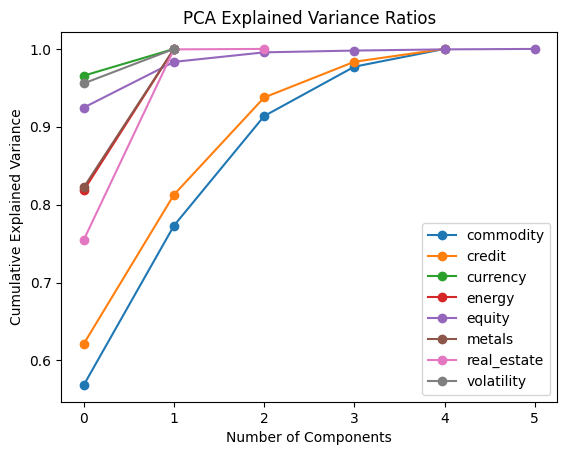

In [ ]:
# Plot Explained Variance Ratios
for asset, variance_ratio in explained_variance_ratios.items():
    plt.plot(np.cumsum(variance_ratio), marker="o", label=asset)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Ratios")
plt.legend()
plt.show()

In [ ]:
# Mutual Information and Surrogate Testing
mi_results = []
asset_pairs = list(itertools.combinations(assets, 2))
for asset1, asset2 in asset_pairs:
    observed_mi, threshold, significant = surrogate_mi_test_shift(asset_classes_discrete[asset1],
                                                                  asset_classes_discrete[asset2])
    mi_results.append({"Asset Pair": (asset1, asset2),
                       "Observed MI": observed_mi,
                       "Threshold": threshold,
                       "Significant": significant})

KeyboardInterrupt: 

In [ ]:
for result in mi_results:
    asset1, asset2 = result["Asset Pair"]
    print((
        f"MI({asset1}, {asset2}): "
        f"{result['Observed MI']:.4f}, "
        f"Threshold: {result['Threshold']:.4f}, "
        f"Significant: {result['Significant']}"
    ))

MI(commodity, credit): 0.0203, Threshold: 0.0132, Significant: True
MI(commodity, currency): 0.0622, Threshold: 0.0124, Significant: True
MI(commodity, energy): 0.1340, Threshold: 0.0135, Significant: True
MI(commodity, equity): 0.0530, Threshold: 0.0149, Significant: True
MI(commodity, metals): 0.0839, Threshold: 0.0125, Significant: True
MI(commodity, real_estate): 0.0513, Threshold: 0.0180, Significant: True
MI(commodity, volatility): 0.0294, Threshold: 0.0119, Significant: True
MI(credit, currency): 0.0499, Threshold: 0.0122, Significant: True
MI(credit, energy): 0.0355, Threshold: 0.0138, Significant: True
MI(credit, equity): 0.0564, Threshold: 0.0142, Significant: True
MI(credit, metals): 0.0343, Threshold: 0.0132, Significant: True
MI(credit, real_estate): 0.0480, Threshold: 0.0172, Significant: True
MI(credit, volatility): 0.0271, Threshold: 0.0118, Significant: True
MI(currency, energy): 0.0720, Threshold: 0.0128, Significant: True
MI(currency, equity): 0.0582, Threshold: 0.01

MI graph
Sparsify - max spanning tree, backboning, thresholding
Degree, degree distribution
Clustering coeff
Density
Modularity : edges within partitions divided by edges outside
Shortest average path
Small worldness coef
Laplacian, non-zero eigenvalue, Fiedler vector

Metric to measure the fit of the partitions
network properties over sliding windows